In [1]:
# https://colab.research.google.com/github/DhavalTaunk08/Transformers_scripts/blob/master/Transformers_multilabel_distilbert.ipynb#scrollTo=yU4TWUBtNKUN
# https://www.kaggle.com/code/kkhandekar/contradiction-detection-distilbert

In [2]:
import torch
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset, DataLoader

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.read_csv('/content/drive/My Drive/6600-project/train.csv')
df['score'] = df['score'] - 1

test = pd.read_csv('/content/drive/My Drive/6600-project/test.csv')
X_test = test['full_text']

In [7]:
df.head(5)

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,2
1,000fe60,I am a scientist at NASA that is discussing th...,2
2,001ab80,People always wish they had the same technolog...,3
3,001bdc0,"We all heard about Venus, the planet without a...",3
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",2


In [8]:
max_len = 512
model_name = 'distilbert-base-cased'
batch_size = 32
epochs = 10
lr = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained(model_name)


In [9]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        text = str(self.data.full_text[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.score[index], dtype=torch.long)
        }

    def __len__(self):
        return self.len


In [10]:
train_df = df.sample(frac = 0.8, random_state = 123)
val_df = df.drop(train_df.index).reset_index(drop = True)
train_df = train_df.reset_index(drop = True)

train_encoded = Triage(train_df,tokenizer,max_len)
val_encoded = Triage(val_df,tokenizer,max_len)

In [11]:
train_params = {'batch_size': batch_size,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': batch_size,
                'shuffle': True,
                'num_workers': 0
                }

train_dataloader = DataLoader(train_encoded, **train_params)
val_dataloader = DataLoader(val_encoded, **test_params)

In [12]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 6)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [13]:
model = DistillBERTClass()
model.to(device)

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

In [14]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=lr)

In [15]:
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [16]:
def checkpoint(model_name,filename):
    """
    Save the model.
    """
    torch.save(model_name.state_dict(),filename)

class EarlyStopper:
    """
    Define an early stopper.
    """
    def __init__(self,patience, min_delta):
        """
        patience: number of epochs with no improvement after which training will be stopped
        min_delta: minimum change in validation loss as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf') # default to positive infnite

    def early_stop(self,validation_loss):
        """
        Moniter the validation loss, end training procedure if the validation loss increases.
        """
        if validation_loss < self.min_validation_loss: # keep tracking the smallest validation loss
            self.min_validation_loss = validation_loss # update the min validation loss if a smaller number occurs
            self.counter = 0
            checkpoint(model,'distilbert.pth') # save the model with a smaller validation loss
        elif validation_loss > (self.min_validation_loss + self.min_delta): # if the validation loss is outside the tolerance bound
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [17]:
def train(dataloader):
    train_loss = 0
    n_batches = len(dataloader)
    pred_labels = []
    actual_labels = []

    model.train()
    for _,data in enumerate(dataloader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        train_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        pred_labels.extend(big_idx.tolist())
        actual_labels.extend(targets.tolist())

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    avg_loss = train_loss / n_batches
    qwk = cohen_kappa_score(actual_labels,pred_labels,weights = 'quadratic')

    return avg_loss,qwk

In [18]:
def test(dataloader):
    model.eval()
    test_loss = 0
    pred_labels = []
    actual_labels = []
    qwk = 0

    n_batches = len(dataloader)
    with torch.no_grad():
        for _, data in enumerate(dataloader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            test_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            pred_labels.extend(big_idx.tolist())
            actual_labels.extend(targets.tolist())

    avg_loss = test_loss / n_batches
    qwk = cohen_kappa_score(actual_labels, pred_labels, weights= 'quadratic')

    return avg_loss, qwk

In [19]:
train_loss = []
train_qwk = []
val_loss = []
val_qwk = []

early_stopper = EarlyStopper(patience=1,min_delta=0.05)

for e in range(epochs):
    train_epoch_loss, train_epoch_qwk = train(train_dataloader)
    val_epoch_loss, val_epoch_qwk = test(val_dataloader)

    print(f'Epoch {e+1}:\nTrain qwk = {train_epoch_qwk:.5f}; Train loss = {train_epoch_loss:.5f}\nValidation qwk = {val_epoch_qwk:.5f}; Validation loss = {val_epoch_loss:.5f}')

    train_loss.append(train_epoch_loss)
    train_qwk.append(train_epoch_qwk)
    val_loss.append(val_epoch_loss)
    val_qwk.append(val_epoch_qwk)

    if early_stopper.early_stop(val_epoch_loss):
        break


Epoch 1:
Train qwk = 0.55900; Train loss = 1.17180
Validation qwk = 0.65534; Validation loss = 1.02820
Epoch 2:
Train qwk = 0.68403; Train loss = 0.99055
Validation qwk = 0.73122; Validation loss = 0.96293
Epoch 3:
Train qwk = 0.73189; Train loss = 0.92447
Validation qwk = 0.72397; Validation loss = 0.91547
Epoch 4:
Train qwk = 0.75864; Train loss = 0.87633
Validation qwk = 0.77357; Validation loss = 0.89747
Epoch 5:
Train qwk = 0.77955; Train loss = 0.83747
Validation qwk = 0.74787; Validation loss = 0.89476
Epoch 6:
Train qwk = 0.79867; Train loss = 0.80063
Validation qwk = 0.73645; Validation loss = 0.90065
Epoch 7:
Train qwk = 0.81906; Train loss = 0.75788
Validation qwk = 0.72534; Validation loss = 1.02098


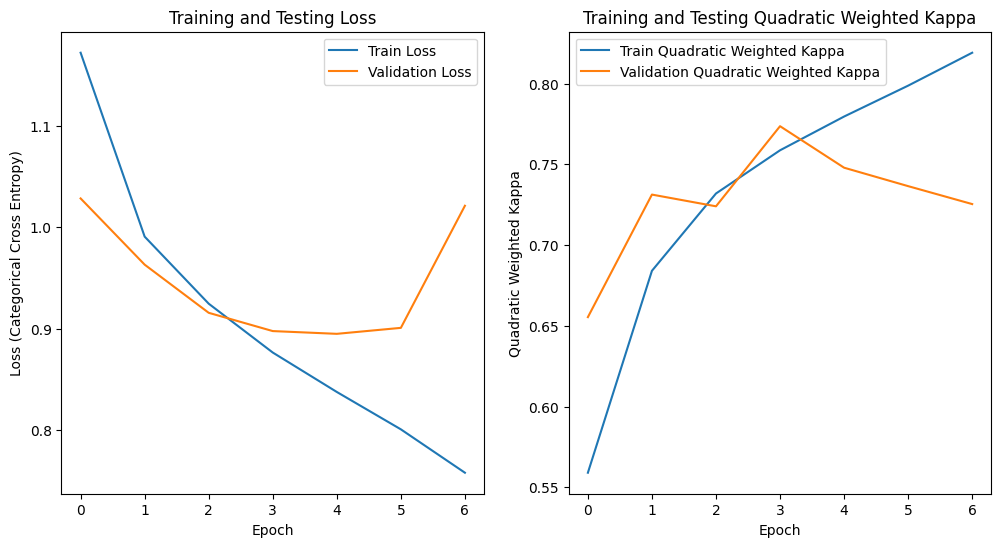

In [22]:
fig = plt.figure(1,figsize = (12,6))
plt.clf()

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
epochs = [int(i) for i in range(len(train_loss))]

ax1.set_title('Training and Testing Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (Categorical Cross Entropy)')
ax1.plot(epochs, train_loss, label='Train Loss')
ax1.plot(epochs, val_loss, label='Validation Loss')
ax1.legend()

ax2.set_title('Training and Testing Quadratic Weighted Kappa')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Quadratic Weighted Kappa')
ax2.plot(epochs, train_qwk, label='Train Quadratic Weighted Kappa')
ax2.plot(epochs, val_qwk, label='Validation Quadratic Weighted Kappa')
ax2.legend()
plt.show()

Training Accuracy:  0.674996388848765
Validation Accuracy:  0.6139843975729558


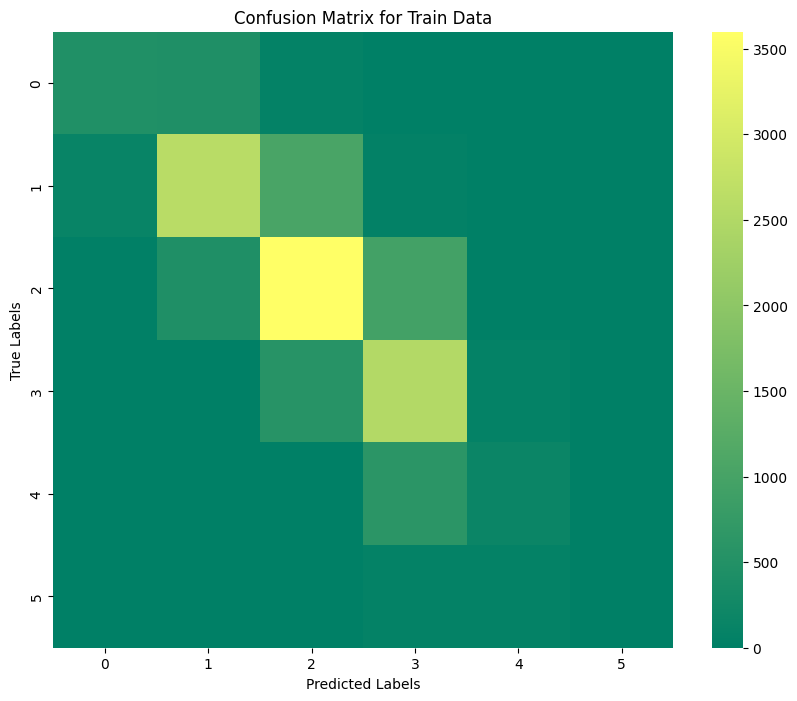

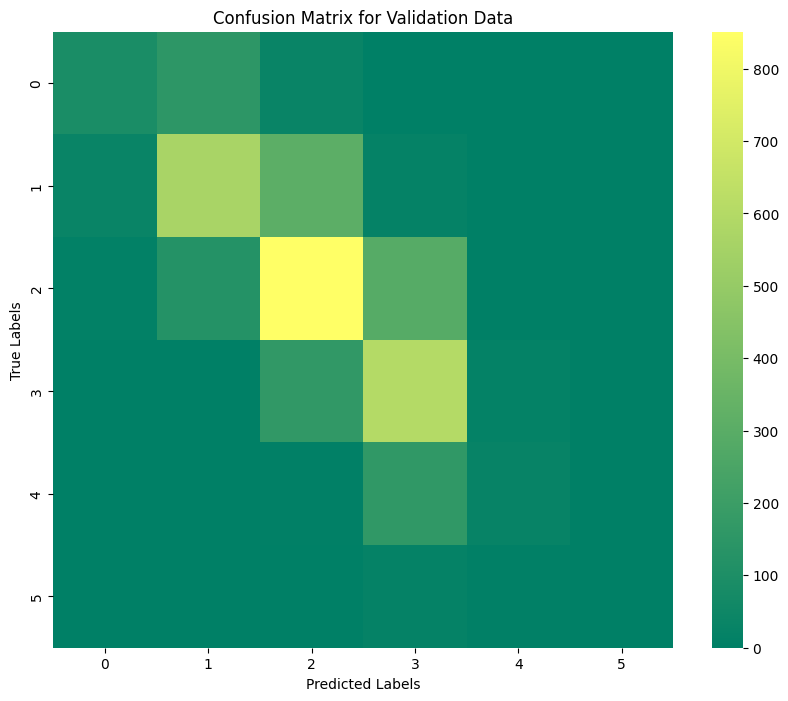

In [21]:
model=DistillBERTClass()
model.load_state_dict(torch.load('distilbert.pth')) # load the best model
model.to(device)
model.eval()

with torch.no_grad(): # make prediction on train, val, test Xs
    y_train = []
    y_train_pred = []
    y_val = []
    y_val_pred = []

    # get pred values and ground truth in format of arrays
    for _, data in enumerate(train_dataloader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        outputs = model(ids, mask).squeeze()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        y_train_pred.extend(big_idx.tolist())
        y_train.extend(targets.tolist())
    for _, data in enumerate(val_dataloader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        outputs = model(ids, mask).squeeze()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        y_val_pred.extend(big_idx.tolist())
        y_val.extend(targets.tolist())

def get_acc(true_data,pred_data): # calculate accuracy for multi-class classification
    correct_count = 0
    for yt,yp in zip(true_data,pred_data):
        if yt==yp:
            correct_count += 1

    return correct_count/len(pred_data)

def print_cm(true_data,pred_data,title):
    plt.figure(figsize = (10,8))
    sns.heatmap(confusion_matrix(true_data,pred_data),cmap = 'summer')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for '+title)
    plt.show()


print('Training Accuracy: ',get_acc(y_train,y_train_pred))
print('Validation Accuracy: ',get_acc(y_val,y_val_pred))
print_cm(y_train,y_train_pred,'Train Data')
print_cm(y_val,y_val_pred,'Validation Data')